In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import utils.nervousness as nervous

## Flow Time

In [4]:
df_plan0_a =  pd.read_csv("data/08a_plan0.csv")
df_plan0_a = df_plan0_a.sort_values(by=["Arrival", "Start"]).reset_index(drop=True)
df_plan0_a

,Job,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_000,14.37,M0,14.37,29,29.00,43.37
1,Job_000,14.37,M1,43.37,78,107.00,121.37
2,Job_000,14.37,M2,121.37,9,116.00,130.37
3,Job_000,14.37,M3,130.37,36,152.00,166.37
4,Job_000,14.37,M4,166.37,49,201.00,215.37
...,...,...,...,...,...,...,...
685,Job_068,4210.59,M5,6927.36,10,2726.77,6937.36
686,Job_068,4210.59,M7,6937.36,12,2738.77,6949.36
687,Job_068,4210.59,M6,6949.36,89,2827.77,7038.36
688,Job_068,4210.59,M9,7038.36,45,2872.77,7083.36


In [5]:
df_plan1_a =  pd.read_csv("data/08a_plan1.csv")
df_plan1_a = df_plan1_a.sort_values(by=["Arrival", "Start"]).reset_index(drop=True)

df_plan2_a =  pd.read_csv("data/08a_plan2.csv")
df_plan2_a = df_plan2_a.sort_values(by=["Arrival", "Start"]).reset_index(drop=True)

In [6]:
T1 = 60 * 24 *1 
P_T_0a, details = nervous.compute_P_T(df_plan0_a, df_plan1_a, T1, verbose = True)
P_T_0a

                       Debug-Info  compute_P_T                        
Vorgänge nach T1              :        541
Planungshorizont T            :    8541.99
----------------------------------------------------------------------
Metric                            Min        Mean         Max
----------------------------------------------------------------------
delta_t (|t−t′|)                 5.38      324.84     1039.42
g(t)                            0.105       0.470       0.997
----------------------------------------------------------------------
Beispiel-Zeilen (Top 5):
    Job Machine Start_plan Start_rev delta_t     g contrib
Job_008      M8   1,447.70  1,714.16  266.46 0.997  265.66
Job_009      M4   1,447.76  1,440.00    7.76 0.997    7.74
Job_009      M7   1,537.76  1,530.00    7.76 0.963    7.47
Job_010      M2   1,450.88  1,603.86  152.98 0.996  152.33
Job_010      M9   1,535.88  1,688.86  152.98 0.964  147.44
-----------------------------------------------------------------

70002.96742911445

In [7]:
def build_pt_table(plan_d: list,
                   minutes_per_day: int = 60 * 24,
                   horizon_mode: str = "fixed",
                   verbose: bool = False,
                   include_zero_row: bool = True) -> pd.DataFrame:
    if len(plan_d) < 2:
        raise ValueError("plan_d muss mindestens zwei Snapshots enthalten.")

    rows      = []
    base_plan = plan_d[0]

    for d in range(1, len(plan_d)):
        T1 = d * minutes_per_day

        # ---------- inkrementell  (Plan d-1 -> Plan d) ----------
        P_T_inc, _ = nervous.compute_P_T(plan_d[d-1], plan_d[d], T1, horizon_mode=horizon_mode, verbose=verbose)
        rows.append({'Base': d-1, 'Next': d, 'P_T': P_T_inc})

        # ---------- basis-orientiert  (Basisplan -> Plan d) ----------
        P_T_base, _ = nervous.compute_P_T(base_plan, plan_d[d], T1, horizon_mode=horizon_mode, verbose=verbose)
        rows.append({'Base': 0, 'Next': d, 'P_T': P_T_base})

    # ---------- Ergebnis-DataFrame ----------
    df_rows = pd.DataFrame(rows, columns=['Base', 'Next', 'P_T'])

    if include_zero_row:
        df_rows = pd.concat([pd.DataFrame([{'Base': 0, 'Next': 0, 'P_T': 0}]), df_rows])

    result = df_rows.drop_duplicates().reset_index(drop=True)
    return result

result = build_pt_table([df_plan0_a, df_plan1_a, df_plan2_a])
result

,Base,Next,P_T
0,0,0,0.000000
1,0,1,70002.967429
2,1,2,114383.213274
3,0,2,124510.420782


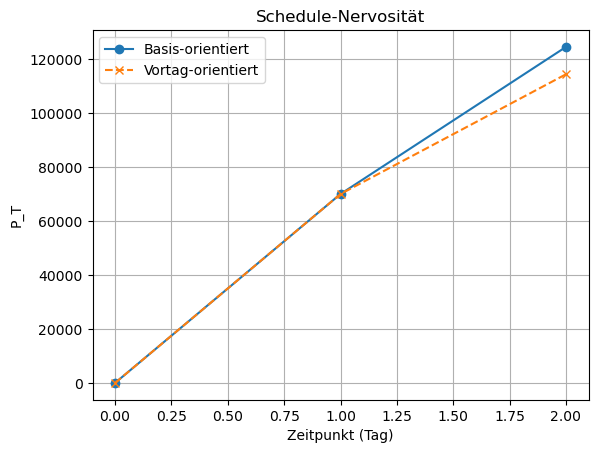

In [8]:
def plot_nervosity(result: pd.DataFrame,
                   title: str = "Schedule-Nervosität",
                   ax: plt.Axes | None = None) -> plt.Axes:
    """
    Zeichnet zwei Linien aus einem Nervositäts-DataFrame.

    result  : DataFrame mit Spalten 'Base', 'Next', 'P_T'
    title   : Plot-Titel (optional)
    ax      : existierende Achse (optional). Wird None übergeben, erzeugt
              die Funktion selbst eine neue Figur und Achse.

    Rückgabe
    --------
    ax      : Achse, auf der geplottet wurde
    """
    if ax is None:
        _, ax = plt.subplots()

    # ---------- Datensätze trennen ----------
    basis = (result[result['Base'] == 0]
             .sort_values('Next')[['Next', 'P_T']])

    incr = (result[result['Next'] - result['Base'] == 1]
            .sort_values('Next')[['Next', 'P_T']])

    # ---------- Nullpunkt sicherstellen ----------
    if not ((incr['Next'] == 0) & (incr['P_T'] == 0)).any():
        incr = (pd.concat([pd.DataFrame([{'Next': 0, 'P_T': 0}]), incr])
                  .sort_values('Next'))

    # ---------- Plot ----------
    ax.plot(basis['Next'], basis['P_T'],
            marker='o', linestyle='-',  label='Basis-orientiert')

    ax.plot(incr['Next'], incr['P_T'],
            marker='x', linestyle='--', label='Vortag-orientiert')

    ax.set_xlabel('Zeitpunkt (Tag)')
    ax.set_ylabel('P_T')
    ax.set_title(title)
    ax.grid(True)
    ax.legend()

    return ax
    
fig, ax = plt.subplots()
plot_nervosity(result, ax=ax)          
plt.show()

## Tardiness

In [10]:
df_plan0_b =  pd.read_csv("data/08b_plan0.csv")
df_plan0_b = df_plan0_b.sort_values(by=["Arrival", "Start"]).reset_index(drop=True)
df_plan0_b

,Job,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_000,14.37,2362.556555,M0,14.37,29,43.37,0.000000
1,Job_000,14.37,2362.556555,M1,43.37,78,121.37,0.000000
2,Job_000,14.37,2362.556555,M2,121.37,9,130.37,0.000000
3,Job_000,14.37,2362.556555,M3,130.37,36,166.37,0.000000
4,Job_000,14.37,2362.556555,M4,166.37,49,215.37,0.000000
...,...,...,...,...,...,...,...,...
685,Job_068,4210.59,7587.222818,M5,8562.02,10,8572.02,1173.857182
686,Job_068,4210.59,7587.222818,M7,8582.08,12,8594.08,1173.857182
687,Job_068,4210.59,7587.222818,M6,8594.08,89,8683.08,1173.857182
688,Job_068,4210.59,7587.222818,M9,8683.08,45,8728.08,1173.857182


In [11]:
df_plan1_b =  pd.read_csv("data/08b_plan1.csv")
df_plan1_b = df_plan1_a.sort_values(by=["Arrival", "Start"]).reset_index(drop=True)

df_plan2_b =  pd.read_csv("data/08b_plan2.csv")
df_plan2_b = df_plan2_a.sort_values(by=["Arrival", "Start"]).reset_index(drop=True)

In [25]:
T1 = 60 * 24 *1 
nervous.compute_P_T(df_plan0_b, df_plan1_b, T1, verbose = True)
P_T_0a

                       Debug-Info  compute_P_T                        
Vorgänge nach T1              :        553
Planungshorizont T            :   10186.71
----------------------------------------------------------------------
Metric                            Min        Mean         Max
----------------------------------------------------------------------
delta_t (|t−t′|)               191.50     1561.29     2771.96
g(t)                            0.079       0.369       0.840
----------------------------------------------------------------------
Beispiel-Zeilen (Top 5):
    Job Machine Start_plan Start_rev  delta_t     g  contrib
Job_008      M7   2,259.82  1,575.60   684.22 0.770   526.62
Job_008      M4   2,348.82  1,664.60   684.22 0.750   513.11
Job_008      M8   2,618.06  1,714.16   903.90 0.694   627.71
Job_009      M4   3,393.66  1,440.00 1,953.66 0.562 1,097.61
Job_009      M7   3,618.78  1,530.00 2,088.78 0.529 1,104.95
-----------------------------------------------------

70002.96742911445

In [21]:
result_tardiness = build_pt_table([df_plan0_b, df_plan1_b, df_plan2_b])
result_tardiness 

,Base,Next,P_T
0,0,0,0.000000
1,0,1,285417.946638
2,1,2,114383.213274
3,0,2,308920.277557


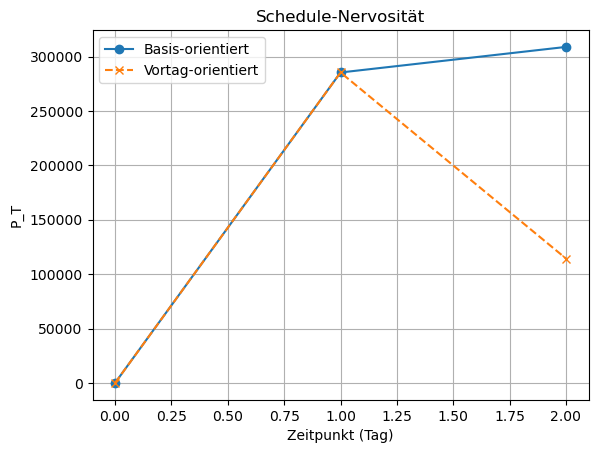

In [23]:
fig, ax = plt.subplots()
plot_nervosity(result_tardiness , ax=ax)          
plt.show()